In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys,os,json
sys.path.append('../..')
import Project.new_profiles as pnp
import Project.profiles as pp
from Project.constants import Constants as pc
import Project.plot_assist as pa
from Project.fit_line import Fitline as fl
import matplotlib
from getdist import MCSamples, plots
from tqdm.notebook import tqdm
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

In [2]:
sparcd = json.load(open('../../obs_RC_v4/Output/result_dicts/sparc_fit_dict_comb.json','r'))
sel_gals = json.load(open('../../obs_RC_v4/Output/result_dicts/selected_gals_comb.json','r'))

D631-7 [48.16 49.59]
DDO064 [2.77 2.91]
DDO168 [35.12 37.66]
DDO170 [2.91 3.24]
ESO079-G014 [17.59 17.64]
ESO563-G021 [113.37 113.65]
F561-1 [0.23 0.68]
F563-1 [3.01 3.12]
F563-V2 [2.  2.2]
F571-8 [24.85 26.25]
F571-V1 [0.84 0.86]
F579-V1 [0.47 0.53]
IC2574 [557.52 609.73]
IC4202 [170.   170.38]
NGC0055 [27.09 27.34]
NGC0100 [10.07 10.57]
NGC0247 [6.63 6.99]
NGC0289 [0.11 0.33]
NGC1705 [1.22 1.43]
NGC2903 [25.17 25.2 ]
NGC2915 [3.16 3.55]
NGC2976 [16.81 16.97]
NGC3109 [121.92 142.06]
NGC3198 [15.21 16.13]
NGC3521 [0.73 0.91]
NGC3726 [1.05 1.08]
NGC3741 [0.39 2.05]
NGC3769 [0.88 0.91]
NGC3877 [6.62 6.69]
NGC3893 [0.91 0.93]
NGC3953 [0.86 0.99]
NGC3972 [1.69 1.78]
NGC3992 [1.31 1.34]
NGC4010 [5.12 5.57]
NGC4085 [5.3  5.61]
NGC4088 [0.06 0.3 ]
NGC4100 [0.03 0.2 ]
NGC4138 [0.09 0.09]
NGC4157 [0.4  0.63]
NGC4217 [ 9.62 10.38]
NGC5005 [0.16 0.28]
NGC5033 [0.74 1.11]
NGC5585 [14.21 14.41]
NGC5907 [0.71 1.1 ]
NGC5985 [0.43 3.15]
NGC6195 [1.29 1.37]
NGC7331 [0.44 0.61]
NGC7814 [0.   0.46]
PGC51

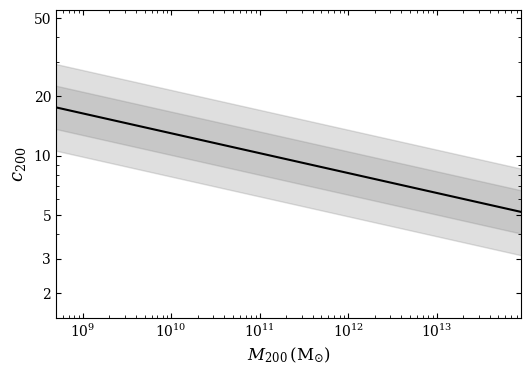

In [7]:
for gal in sparcd['lcdm_reg']:
    lnZ_vmax = sparcd['lcdm_vmax'][gal]['delta_lnZ']
    lnZ_reg = sparcd['lcdm_reg'][gal]['delta_lnZ']
    if np.abs(lnZ_reg) < np.abs(lnZ_vmax):
        print (gal, np.around([np.abs(lnZ_reg), np.abs(lnZ_vmax)],2))

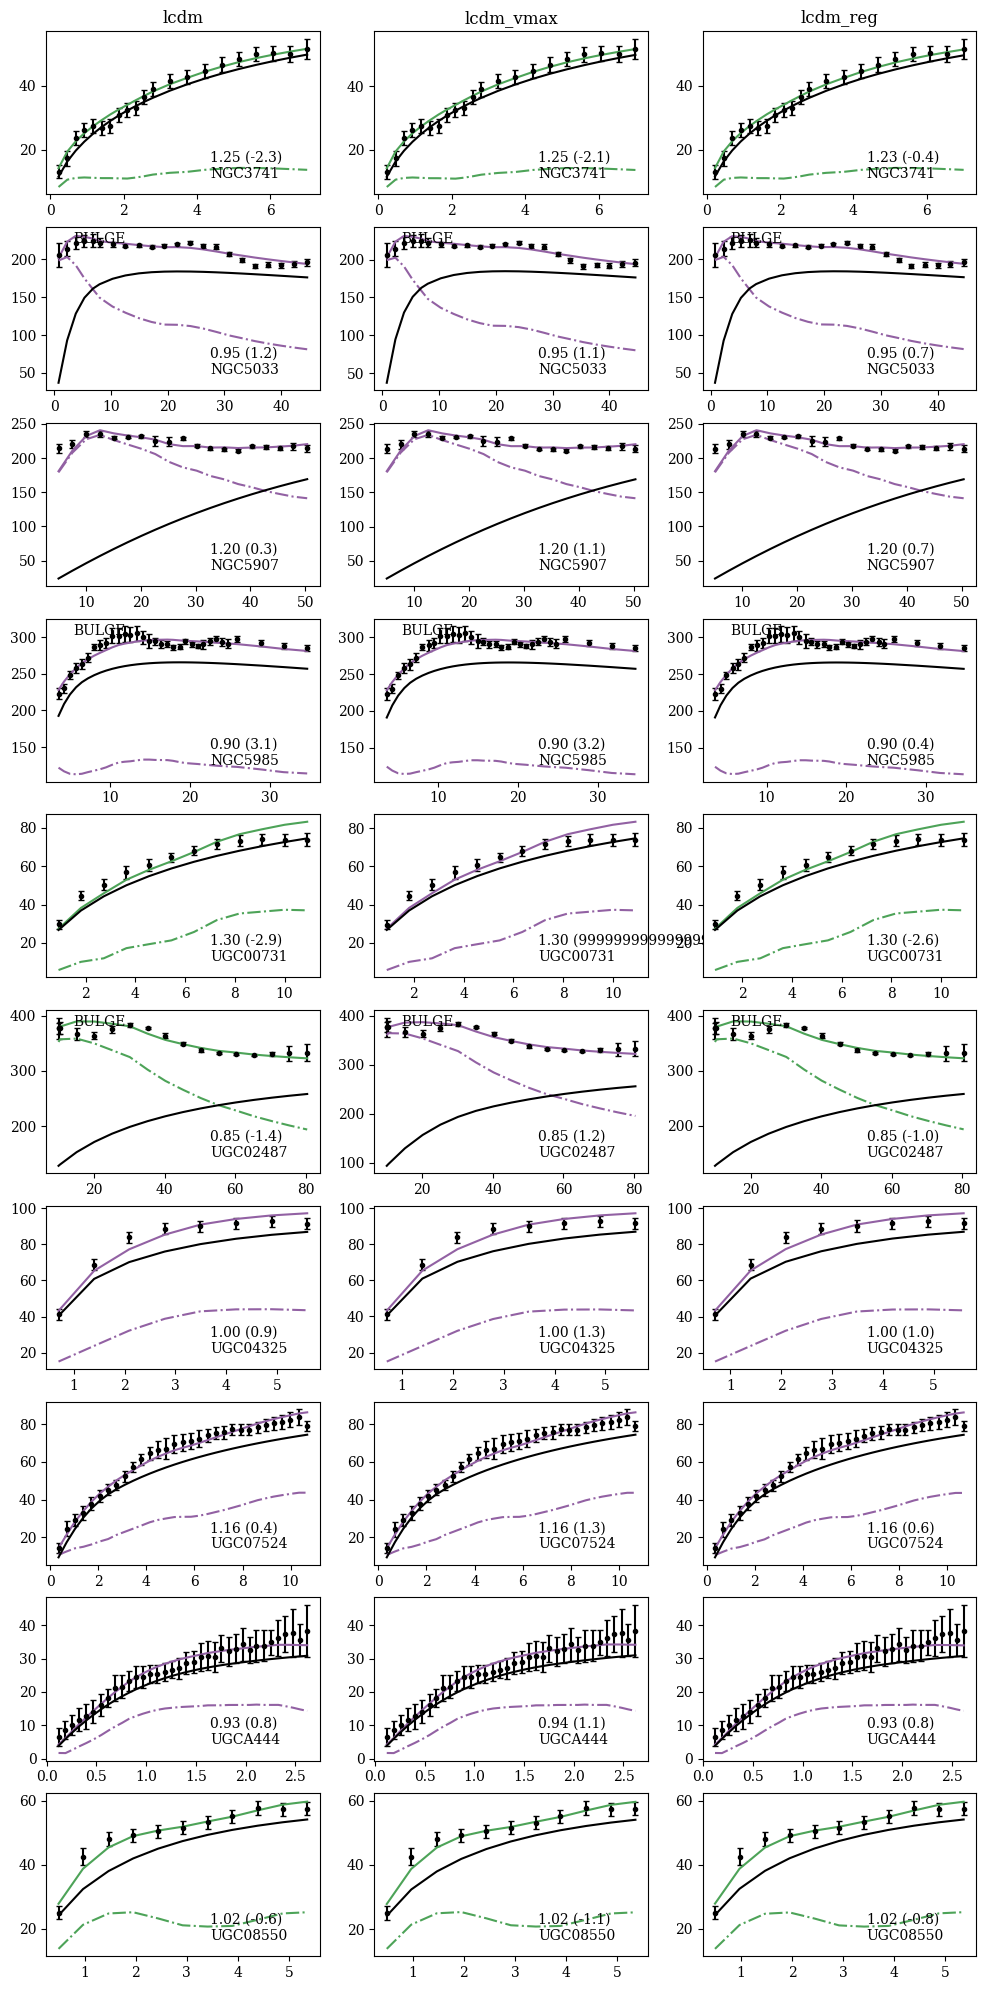

In [13]:
reg_vmax_gals = ['NGC3741','NGC5033', 'NGC5907', 'NGC5985', 'UGC00731', 'UGC02487',
                 'UGC04325', 'UGC07524', 'UGCA444', 'UGC08550']
gals = reg_vmax_gals
priors = ['lcdm','lcdm_vmax','lcdm_reg']
fig,axs = plt.subplots(len(gals),len(priors), figsize = (12,len(gals)*2.5))
for i in range(len(gals)):
    gal = gals[i]
    for ax,prior in zip(axs[i],priors):
        gald = sparcd[prior][gal]
        ax.errorbar(gald['r'],gald['vc'],gald['ve'],fmt = '.', color = 'k', capsize = 2)
        bestfit = sparcd[prior][gal]['best_fit']
        clr = pa.green if bestfit == 'cusp_fit' else pa.purple
        ax.plot(gald['r'],gald[bestfit]['vcmodel'],color = clr)
        ax.plot(gald['r'],gald[bestfit]['vbary'],color =clr, ls= '-.')
        vdm = np.sqrt(np.array(gald[bestfit]['vcmodel'])**2 - np.array(gald[bestfit]['vbary'])**2)
        ax.plot(gald['r'],vdm,color = 'k')
        ax.text(0.6,0.1,gal,transform = ax.transAxes)
        lm = gald[bestfit]['lm'][0]
        c2 = gald[bestfit]['c200'][0]
        rs = pnp.rs_nfw(lm,c2)
        vmax = pp.v_nfw(lm,rs,2.16258*rs)
        vflat = gald['vflat']
        lZ = gald['delta_lnZ']
        ax.text(0.6,0.2,'%.2f (%.1f)'%((vmax/vflat),lZ),transform = ax.transAxes)
        if gald['bulge']:
            ax.text(0.1,0.9,'BULGE',transform = ax.transAxes)
        
for i in range(len(priors)):
    axs[0][i].set_title(priors[i])

In [41]:
def get_scat_MCR(m2,c2):
    lm = np.log10(m2)
    lc = np.log10(c2)
    lc_pred = pp.lc200_SR(lm)
    scatt = np.sqrt(((lc_pred - lc)**2).sum())/np.sqrt(len(m2)-1)
    return scatt
def get_scat_SHM(m2,ms):
    lm = np.log10(m2)
    ls = np.log10(ms)
    ls_pred = pnp.lmstar_behroozi_19(lm)
    scatt = np.sqrt(((ls_pred - ls)**2).sum())/np.sqrt(len(m2)-1)
    return scatt

In [48]:
priors = ['flat_reg','lcdm_reg']
sigmas = {'mcr':{},'shm':{}}
for prior in priors:
    M2,C2,Ms = [],[],[]
    for gal in sel_gals[prior]:
        bestfit = sparcd[prior][gal]['best_fit']
        gald = sparcd[prior][gal][bestfit]
        m2 = gald['m200'][0]
        c2 = gald['c200'][0]
        ms = gald['mstar'][0]
        M2.append(m2)
        C2.append(c2)
        Ms.append(ms)
    sigmas['mcr'][prior] = get_scat_MCR(np.array(M2),np.array(C2))
    sigmas['shm'][prior] = get_scat_SHM(np.array(M2),np.array(Ms))

F568-V1
NGC4013
NGC4088
NGC5907
NGC7814
PGC51017
UGC07690
UGCA444
F568-V1
NGC4013
NGC4088
NGC5907
NGC7814
PGC51017
UGC07690
UGCA444


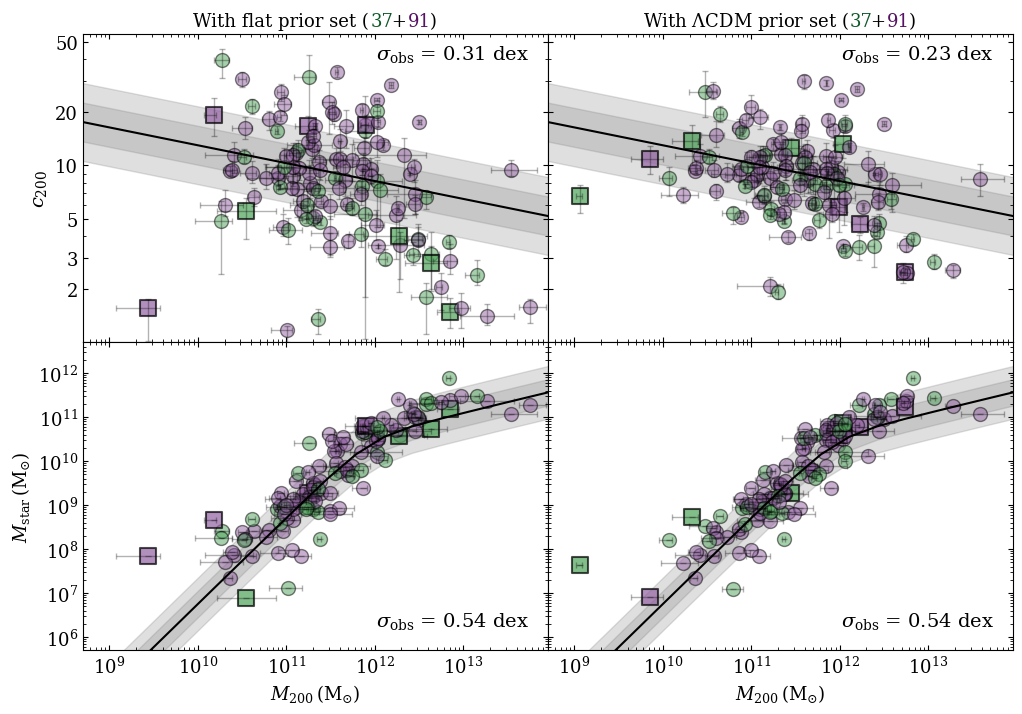

In [60]:
fig,axs = plt.subplots(2,2,figsize = (12,8),gridspec_kw = {'wspace':0,'hspace':0})
ax1,ax2 = axs
ax1 = pa.axs_MCR(axs = ax1)
ax2 = pa.axs_SHM(axs = ax2)
priors = ['flat_reg','lcdm_reg']
ax1[1].set_ylabel('')
ax2[1].set_ylabel('')
flat_cnt = [0,0]
lcdm_cnt = [0,0]
for ax_1,ax_2, prior in zip(ax1,ax2,priors):
    ax_1.tick_params(axis = 'both', labelsize = 13)
    ax_2.tick_params(axis = 'both', labelsize = 13)
    ax_1.set_xlabel('')
    ax_1.set_xticklabels([])
    ax_2.set_ylim(5e5,5e12)
    ax_1.set_ylim(1,ax_1.get_ylim()[1])
    for gal in sel_gals[prior]:
        # continue
        bestfit = sparcd[prior][gal]['best_fit']
        if bestfit == 'cusp_fit':
            if prior == 'flat_reg':
                flat_cnt[0] += 1
            elif prior == 'lcdm_reg':
                lcdm_cnt[0] += 1
        else:
            if prior == 'flat_reg':
                flat_cnt[1] += 1
            elif prior == 'lcdm_reg':
                lcdm_cnt[1] += 1
        mcr = sparcd[prior][gal][bestfit]['MCR']
        shm = sparcd[prior][gal][bestfit]['SHM']
        
        if sparcd[priors[0]][gal]['best_fit'] ==  sparcd[priors[1]][gal]['best_fit']:
            pa.scatt_MCR(ax_1,mcr,edgecolor = 'k',ealpha = 0.3)
            pa.scatt_SHM(ax_2,shm,edgecolor = 'k',ealpha = 0.3)
        else:
            pa.scatt_MCR(ax_1,mcr,marker = 's',alpha = 0.7,linewidth = 1.5, s = 120, 
                         ealpha = 0.3, edgecolor = 'k')
            pa.scatt_SHM(ax_2,shm,marker = 's',alpha = 0.7,linewidth = 1.5, s = 120, 
                         ealpha = 0.3, edgecolor = 'k')

ax1[1].tick_params(right = True)
ax1[1].set_yticklabels([])
ax2[1].tick_params(right = True)
ax2[1].set_yticklabels([])


ax1[0].text(0.63,0.92,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['mcr']['flat_reg']),transform = ax1[0].transAxes, size = 14)
ax1[1].text(0.63,0.92,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['mcr']['lcdm_reg']),transform = ax1[1].transAxes, size = 14)
ax2[0].text(0.63,0.08,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['shm']['flat_reg']),transform = ax2[0].transAxes, size = 14)
ax2[1].text(0.63,0.08,'$\sigma_{\mathrm{obs}}$ = %.2f dex'%(sigmas['shm']['lcdm_reg']),transform = ax2[1].transAxes, size = 14)


ax1[0].set_title('With flat prior set (    +    )',size = 13)
ax1[1].set_title('With $\Lambda$CDM prior set (    +    )',size = 13)
ax1[0].text(0.62, 1.028,flat_cnt[0], size = 13, color = pa.gn(0.1), transform = ax1[0].transAxes)
ax1[0].text(0.70, 1.028,flat_cnt[1], size = 13, color = pa.pr(0.9),transform = ax1[0].transAxes)
ax1[1].text(0.65, 1.028,lcdm_cnt[0], size = 13, color = pa.gn(0.1), transform = ax1[1].transAxes)
ax1[1].text(0.73, 1.028,lcdm_cnt[1], size = 13, color = pa.pr(0.9),transform = ax1[1].transAxes);

plt.savefig('../Output/paper1/SPARC_fit_results.pdf',bbox_inches = 'tight',dpi = 300)

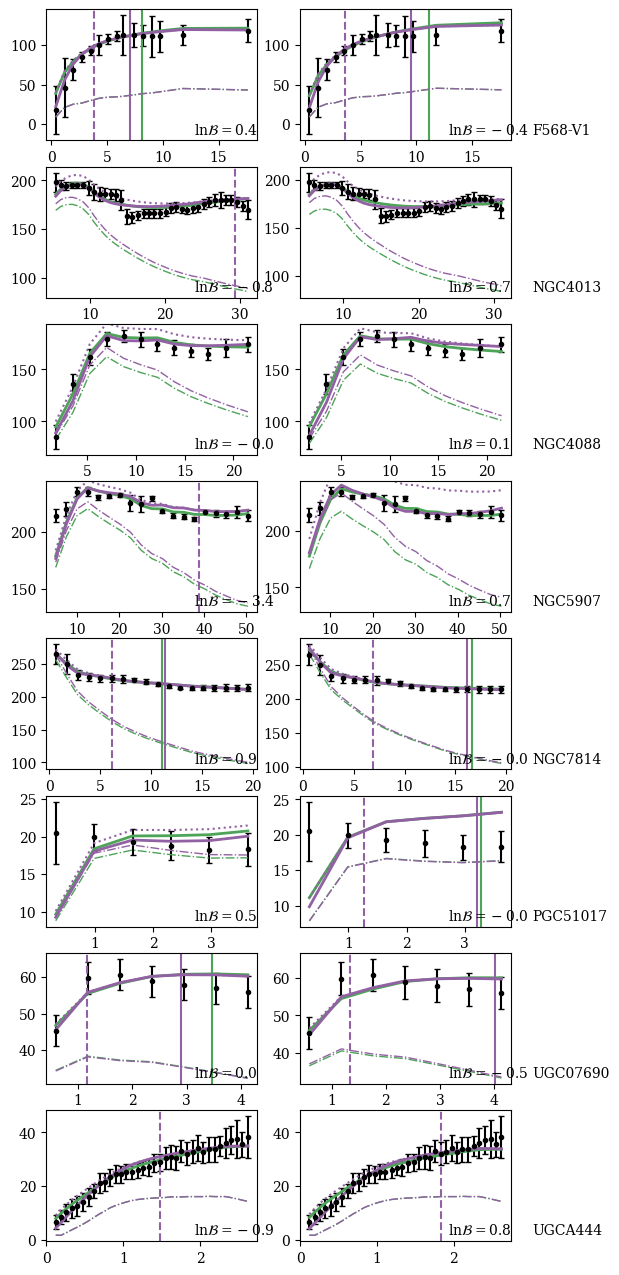

In [11]:
gals = ['F568-V1', 'NGC4013', 'NGC4088', 'NGC5907', 'NGC7814', 'PGC51017', 'UGC07690', 'UGCA444']
priors = ['flat_reg','lcdm_reg']
fig,axs = plt.subplots(8,2,figsize = (6,2*8))
for i in range(8):
    for j in range(2):
        pa.plot_RC(gals[i],sparcd,prior = priors[j],ax = axs[i][j])
        axs[i][j].text(0.7,0.05,'$\mathrm{ln}\mathcal{B} = %.1f$'%sparcd[priors[j]][gals[i]]['delta_lnZ'],
                      transform = axs[i][j].transAxes)
    axs[i][j].text(1.1,0.05,gals[i],
                    transform = axs[i][j].transAxes)

In [12]:
prb_gals = ['F568-V1', 'NGC4013', 'NGC4088', 'NGC5907', 'NGC7814', 'PGC51017', 'UGC07690', 'UGCA444']
res_all = {}
res_brr = {}
for prior in ['flat_reg','lcdm_reg']:
    res_all[prior] = []
    res_brr[prior] = []
    for gal in sparcd[prior].keys():
        res_all[prior].append(sparcd[prior][gal]['delta_lnZ'])
        if gal in prb_gals:
            continue
        else:
            res_brr[prior].append(sparcd[prior][gal]['delta_lnZ'])

In [38]:
pers = []
priors = ['flat_reg','lcdm_reg']
for prior in priors:
    lz = np.abs(np.array(res_brr[prior]))
    lz1 = lz[5 < lz]
    lz2 = lz[(3 < lz) & (lz <= 5)]
    lz3 = lz[(1 < lz) & (lz <= 3)]
    lz4 = lz[(0 < lz) & (lz <= 1)]
    pers = [len(lz1)/len(lz),len(lz2)/len(lz),len(lz3)/len(lz),len(lz4)/len(lz)]
    pers = np.around(np.array(pers)*100,1)
    print (prior)
    print (f'   > 5 :: {pers[0]}, \n (3,5) :: {pers[1]}, \n (1,3) :: {pers[2]} \n (0,1) :: {pers[3]}')

flat_reg
   > 5 :: 33.9, 
 (3,5) :: 8.7, 
 (1,3) :: 33.9 
 (0,1) :: 23.6
lcdm_reg
   > 5 :: 35.4, 
 (3,5) :: 7.9, 
 (1,3) :: 33.9 
 (0,1) :: 22.8


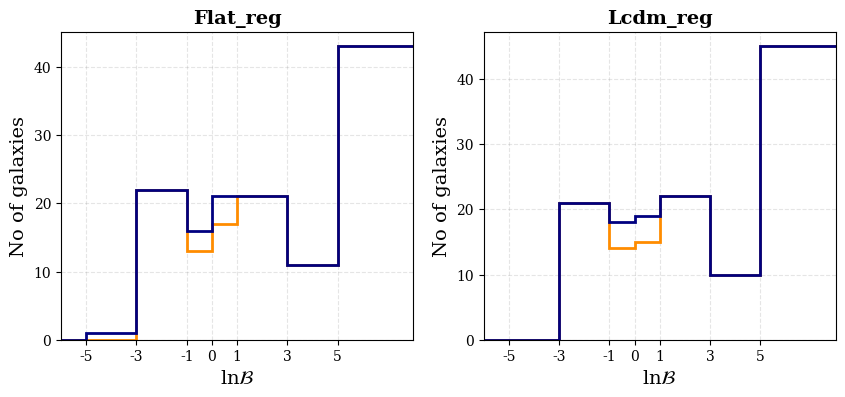

In [36]:
fig,axs = plt.subplots(1,2,figsize = (10,4))
titles = ['Flat_reg','Lcdm_reg']
for i in range(2):
    prior = ['flat_reg','lcdm_reg'][i]
    ax = axs[i]
    ax.hist(res_brr[prior],bins = [-10,-5,-3,-1,0,1,3,5,1000],histtype = 'step',color = (1,1,1),edgecolor = 'darkorange',lw = 2)
    ax.hist(res_all[prior],bins = [-10,-5,-3,-1,0,1,3,5,1000],histtype = 'step',color = (1,1,1),edgecolor = 'navy',lw = 2)
    ax.set_xticks([-5,-3,-1,0,1,3,5])
    ax.set_xticklabels([-5,-3,-1,0,1,3,5])
    ax.set_xlim(-6,8)
    ax.grid(color = 'grey',alpha = 0.2,ls = '--')
    ax.set_ylabel('No of galaxies',size = 14)
    ax.set_xlabel('ln$\mathcal{B}$',size = 14)
    ax.set_title(titles[i],size = 14, fontweight = 'bold')
# plt.savefig('../Output/plots_for_report/sparc_distrubtion_of_lnZ.png',bbox_inches = 'tight',dpi = 300)

In [43]:
prior = 'flat_reg'
Mstar,eMstar,Mgas,Rdgas,Rdstar,clrs = [],[],[],[],[],[]
for gal in sparcd[prior].keys():
    model = sparcd[prior][gal]['best_fit']
    Mstar.append(sparcd[prior][gal][model]['mstar'][0])
    eMstar.append(sparcd[prior][gal][model]['mstar'][1])
    Mgas.append(sparcd[prior][gal][model]['mgas'][0])
    Rdgas.append(sparcd[prior][gal][model]['rdgas'][0])
    Rdstar.append(sparcd[prior][gal][model]['rdstar'][0])
    clr = pa.green if model == 'cusp_fit' else pa.purple
    clrs.append(clr)
Mstar = np.array(Mstar)
eMstar = np.array(eMstar)
Mgas = np.array(Mgas)
Rdgas = np.array(Rdgas)
Rdstar = np.array(Rdstar)
eMgas = Mgas*0.1
eRdgas = Rdgas*0.1
eRdstar = Rdstar*0.1

In [78]:
line1 = fl(np.log10(Mstar),np.log10(Mgas),xerr = eMstar/Mstar, yerr = eMgas/Mgas,
           prior = 'flat', m_prior = [0.1,2], c_prior = [0.1,10])
line2 = fl(np.log10(Mgas),np.log10(Rdgas),xerr = eMgas/Mgas, yerr = eRdgas/Rdgas,
           prior = 'flat', m_prior = [0.1,10], c_prior = [-10,0])
line3 = fl(np.log10(Rdgas),np.log10(Rdstar),xerr = eRdgas/Rdgas, yerr = eRdstar/Rdstar,
           prior = 'flat', m_prior = [0.1,2], c_prior = [-1,1])
line1.fit()
line2.fit()
line3.fit()

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=../Output/Ultra/line, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-336641.97, Lmax=-267.80
DEBUG:ultranest:iteration=40, ncalls=441, regioncalls=1640, ndraw=40, logz=-195466.37, remainder_fraction=100.0000%, Lmin=-192472.51, Lmax=-267.80
DEBUG:ultranest:iteration=80, ncalls=490, regioncalls=3600, ndraw=40, logz=-159922.43, remainder_fraction=100.0000%, Lmin=-159750.82, Lmax=-267.80
DEBUG:ultranest:iteration=90, ncalls=502, regioncalls=4080, ndraw=40, logz=-152728.73, remainder_fraction=100.0000%, Lmin=-152123.33, Lmax=-267.80
DEBUG:ultranest:iteration=120, ncalls=534, regioncalls=5360, ndraw=40, logz=-131238.26, remainder_fraction=100.0000%, Lmin=-129890.08, Lmax=-267.80
DEBUG:ultranest:iteration=160, ncalls=577, regioncalls=7080, ndraw=40, logz=-108647.94, remainder_fraction=100.0000%, Lmin=-108514.71, Lmax=-267.80
DEBUG:ultranest:iteration=180, ncalls=599, regioncalls=7960, ndraw=40, logz=-101051.32, remainder_fraction=100.0000%, Lmin=-1

KeyboardInterrupt: 

triangle (contour) plot saved in ../Output/plots_for_report/lmstar_lmgas_fit_contours.pdf
triangle (contour) plot saved in ../Output/plots_for_report/lmgas_rdgas_fit_contours.pdf
triangle (contour) plot saved in ../Output/plots_for_report/rdgas_rdstar_fit_contours.pdf


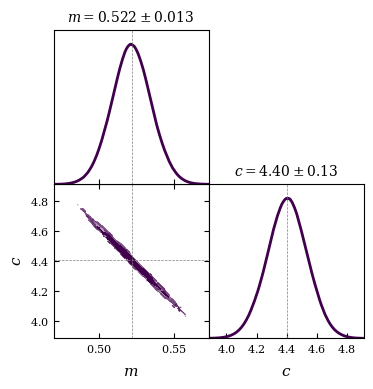

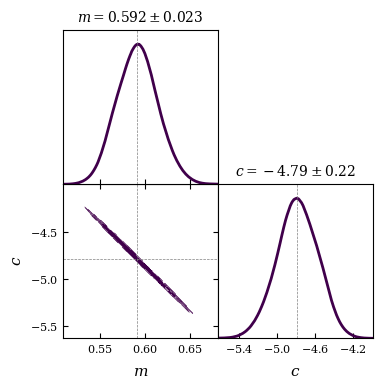

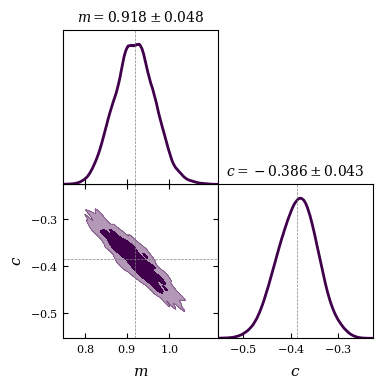

In [45]:
line1.getdict_contour('../Output/plots_for_report/lmstar_lmgas_fit_contours.pdf')
line2.getdict_contour('../Output/plots_for_report/lmgas_rdgas_fit_contours.pdf')
line3.getdict_contour('../Output/plots_for_report/rdgas_rdstar_fit_contours.pdf')

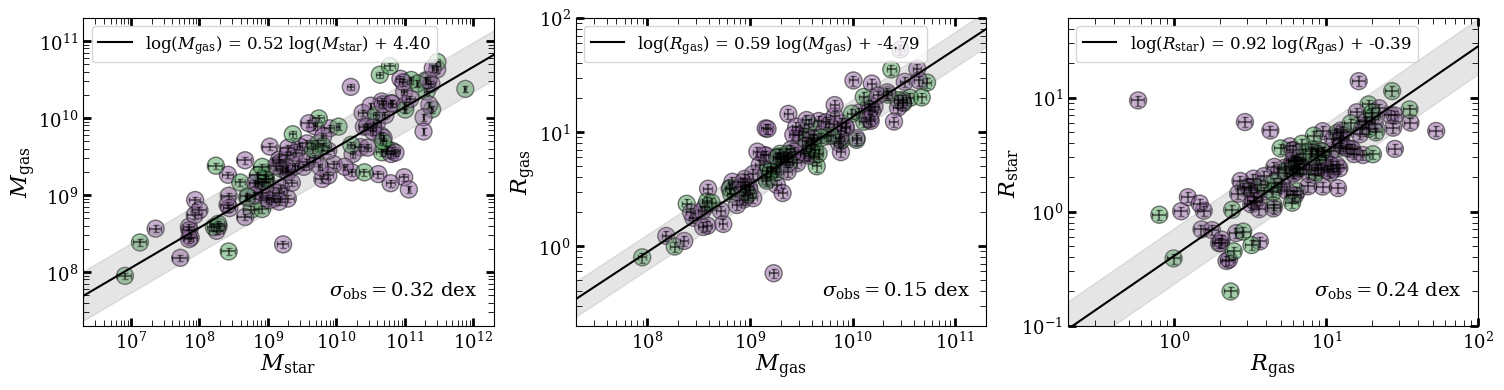

In [46]:
fig,axs = plt.subplots(1,3,figsize = (18,4))
mstar,mgas,rdstar,rdgas = '$M_{\mathrm{star}}$','$M_{\mathrm{gas}}$','$R_{\mathrm{star}}$','$R_{\mathrm{gas}}$'
ax1 = line1.plot_line(mstar,mgas,xlim = [np.log10(2e6),np.log10(2e12)], ylim =[np.log10(2e7),np.log10(2e11)], clr = clrs,
                errorbars = [eMstar,eMgas], alpha = 0.5, s = 150, ax = axs[0],
                xy_names = [' log$(M_{\mathrm{star}})$','log$(M_{\mathrm{gas}})$'])
ax2 = line2.plot_line(mgas,rdgas,ylim = [np.log10(0.2),np.log10(100)],xlim = [np.log10(2e7),np.log10(2e11)],
                clr = clrs, errorbars = [eMgas,eRdgas], alpha = 0.5, s = 150, ax = axs[1],
                xy_names = [' log$(M_{\mathrm{gas}})$','log$(R_{\mathrm{gas}})$'])
ax3 = line3.plot_line(rdgas,rdstar,ylim = [np.log10(0.1),np.log10(50)],xlim = [np.log10(0.2),2],
                clr = clrs, errorbars = [eRdgas,eRdstar], alpha = 0.5, s = 150, ax = axs[2],
                xy_names = [' log$(R_{\mathrm{gas}})$','log$(R_{\mathrm{star}})$'])
for ax in axs:
    ax.tick_params(which = 'both', direction = 'in', top = True, right = True)
    ax.tick_params(which = 'major', length = 6,width = 2,labelsize = 13)
    ax.tick_params(which = 'minor', length = 4)
    ax.legend(prop = {'size':12},loc = 'upper left')
    ax.set_xlabel(ax.get_xlabel(),size = 16, labelpad = 0)
    ax.set_ylabel(ax.get_ylabel(),size = 16, labelpad = 0)

ax1.text(0.6,0.1,'$\sigma_{\mathrm{obs}} = %.2f$ dex'%line1.sig_obs, 
         transform = ax1.transAxes,size = 14)
ax2.text(0.6,0.1,'$\sigma_{\mathrm{obs}} = %.2f$ dex'%line2.sig_obs, 
         transform = ax2.transAxes,size = 14)
ax3.text(0.6,0.1,'$\sigma_{\mathrm{obs}} = %.2f$ dex'%line3.sig_obs, 
         transform = ax3.transAxes,size = 14);

plt.savefig('../Output/paper1/Obs_bry_SR_%s_prior.pdf'%prior,bbox_inches = 'tight',dpi = 300)


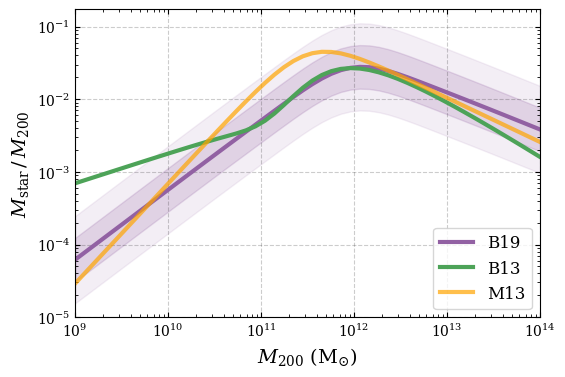

In [16]:
lm = np.linspace(9.,14,50)
ls_b13 = pnp.lmstar_behroozi_13(lm)
ls_b19 = pnp.lmstar_behroozi_19(lm)
ls_nbp = pnp.lmstar_behroozi_nbp(lm)
ls_m13 = pnp.lmstar_moster_13(lm)
fig,ax1 = plt.subplots(1,1,figsize = (6,4))
c1,c2,c4 = pa.purple,pa.green,plt.get_cmap('GnBu')(0.75)
c4 = 'orange'


ax1.plot(10**lm, 10**ls_b19/10**lm, c = c1, lw = 3, label = 'B19')
ax1.fill_between(10**lm, 10**(ls_b19 + 0.3)/10**lm, 10**(ls_b19-0.3)/10**lm, color = c1, alpha = 0.2)
ax1.fill_between(10**lm, 10**(ls_b19 + 0.6)/10**lm, 10**(ls_b19-0.6)/10**lm, color = c1, alpha = 0.1)
ax1.plot(10**lm, 10**ls_b13/10**lm, c = c2, lw = 3, label = 'B13')
ax1.plot(10**lm, 10**ls_m13/10**lm, c = c4, lw = 3, label = 'M13',alpha = 0.7)
# ax1.plot(10**lm, 10**ls_nbp/10**lm, c = c3,ls = '--', lw = 3, label = 'B13 without bump')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(1e9,1e14)
ax1.tick_params(axis='both',which = 'both', direction = 'in', top = True, right = True)
ax1.grid(color = 'k', alpha = 0.2, ls = '--')
ax1.legend(loc = 'lower right',prop = {'size':12})
ax1.set_xlabel(r'$M_{200}\,\,\mathrm{(M_{\odot})}$',size = 14)
ax1.set_ylabel(r'$M_{\mathrm{star}}\,/\,M_{200}}$',size = 14)

plt.savefig('../Output/paper1/SHM.pdf',bbox_inches = 'tight',dpi = 300)